# Lab 3: Compass Heading

## Reading the Raw Magnetometer Values

In [1]:
%matplotlib notebook

import board
import adafruit_bno055

import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

i2c = board.I2C()
imu = adafruit_bno055.BNO055_I2C(i2c)
imu.mode = adafruit_bno055.MAGONLY_MODE

window = 100
interval = 1/20

x_raw = []
y_raw = []
z_raw = []
h = []
t = []

<IPython.core.display.Javascript object>


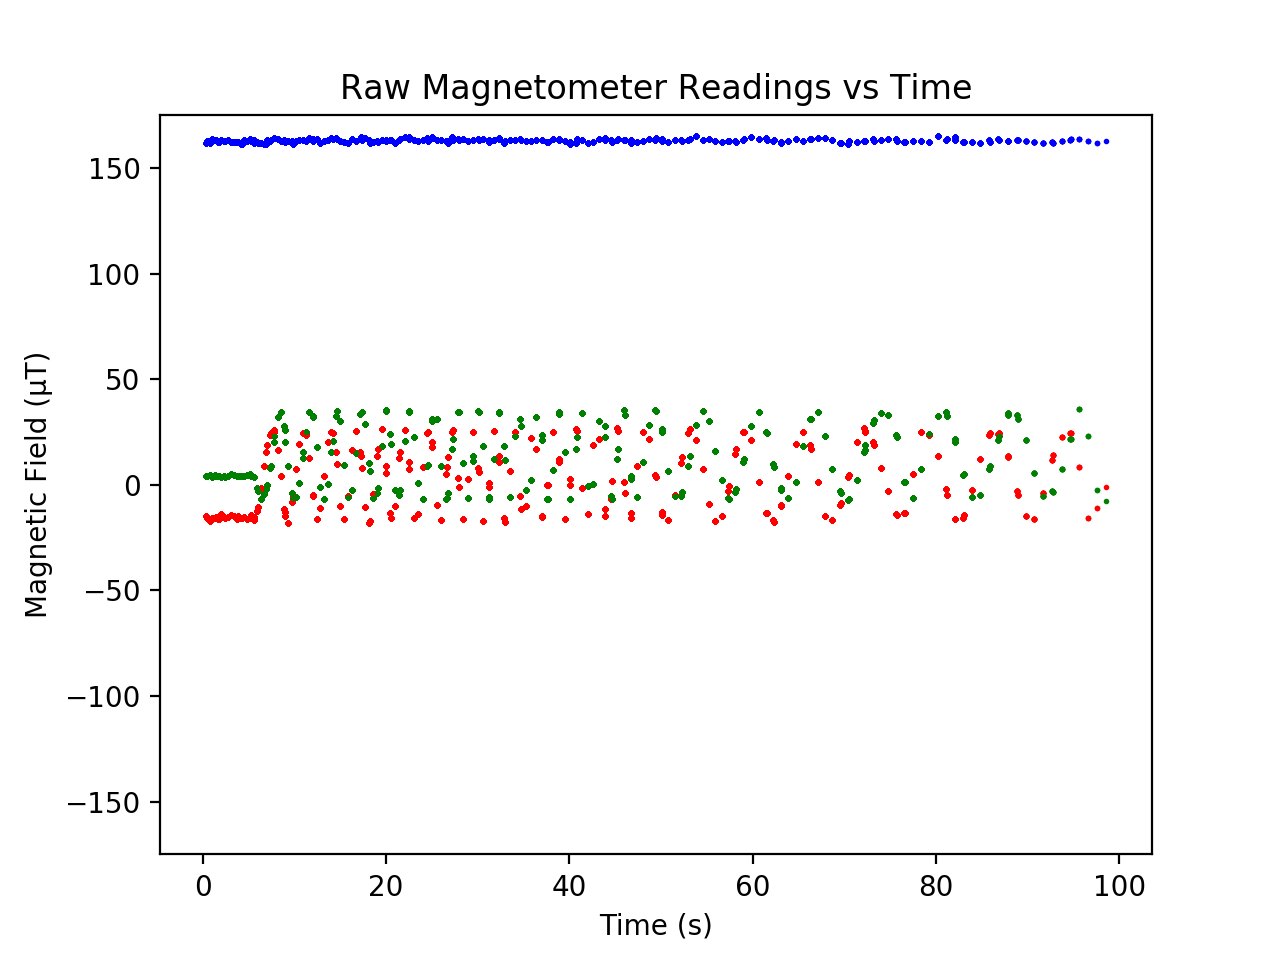

In [2]:
fig_raw, ax_raw = plt.subplots()

plt.title("Raw Magnetometer Readings vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (μT)")
plt.ylim(-175,175)

def animate(i):
    
    x, y, z = imu.magnetic

    if x is not None and y is not None and z is not None: 
        x_raw.append(x)
        y_raw.append(y)
        z_raw.append(z)

        t.append(time.monotonic()-start_time)

        ax_raw.scatter(t, x_raw, s=1, color='r')
        ax_raw.scatter(t, y_raw, s=1, color='g')
        ax_raw.scatter(t, z_raw, s=1, color='b')

start_time = time.monotonic()

x_raw.clear()
y_raw.clear()
z_raw.clear()

ani = animation.FuncAnimation(fig_raw, animate, interval=100)
plt.show()

## Using Magnetometer Readings To Get A Compass Heading

Use your hands to gently and at a moderate pace rotate the entire SCUTTLE 10 times clockwise AND 10 times counterclockwise about ALL three of its axes (x,y,z). 
The result should show one circle and two lines for each axis (different color). 

<IPython.core.display.Javascript object>


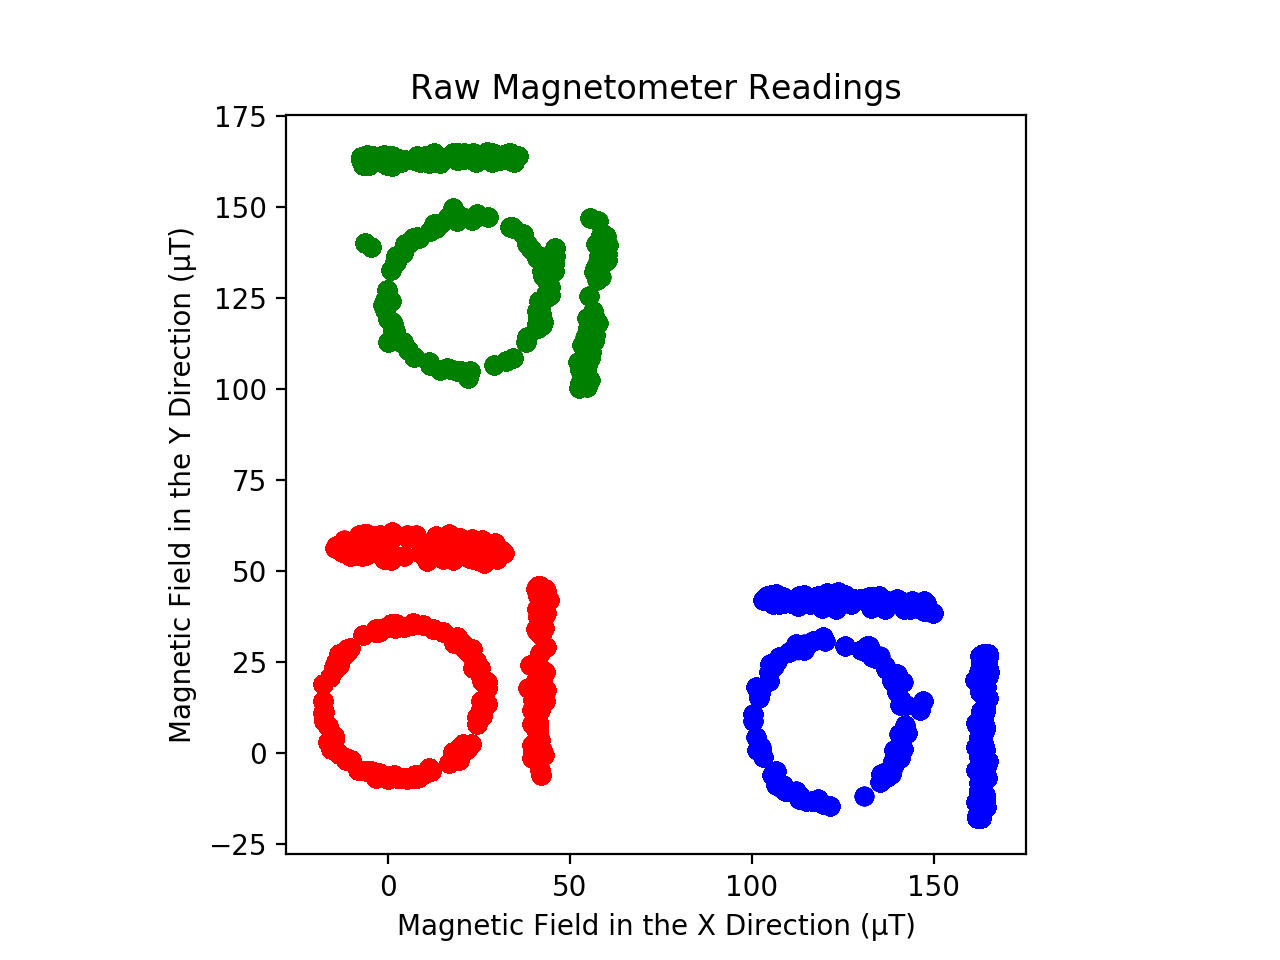

In [3]:
x_raw.clear()
y_raw.clear()
z_raw.clear()
t.clear()

fig_correlation_mag, ax_correlation_mag = plt.subplots()
ax_correlation_mag.set_aspect(1)

plt.title("Raw Magnetometer Readings")
plt.xlabel("Magnetic Field in the X Direction (μT)")
plt.ylabel("Magnetic Field in the Y Direction (μT)")

def animate(i):
    
    x, y, z = imu.magnetic

    if x is not None and y is not None and z is not None: 
        if abs(x) < 500 and abs(y) < 500 and abs(z) < 500:
            x_raw.append(x)
            y_raw.append(y)
            z_raw.append(z)

        ax_correlation_mag.scatter(x_raw, y_raw, color='r')
        ax_correlation_mag.scatter(y_raw, z_raw, color='g')
        ax_correlation_mag.scatter(z_raw, x_raw, color='b')

    plt.pause(interval)
    
ani = animation.FuncAnimation(fig_correlation_mag, animate, interval=100)
plt.show()

## Calibrate the Magnetometer

In [4]:
def calibrate_magnetometer(original_value, axis_min, axis_max):
    temp = (original_value - axis_min) / (axis_max - axis_min)
    calibrated_value = 2*temp - 1
    return calibrated_value

X range:  -17.875 44.1875
Y range:  -7.3125 60.5625
Z range:  100.25 165.125
Final calibration in uTesla: [[-17.875, 44.1875], [-7.3125, 60.5625], [100.25, 165.125]]


<IPython.core.display.Javascript object>


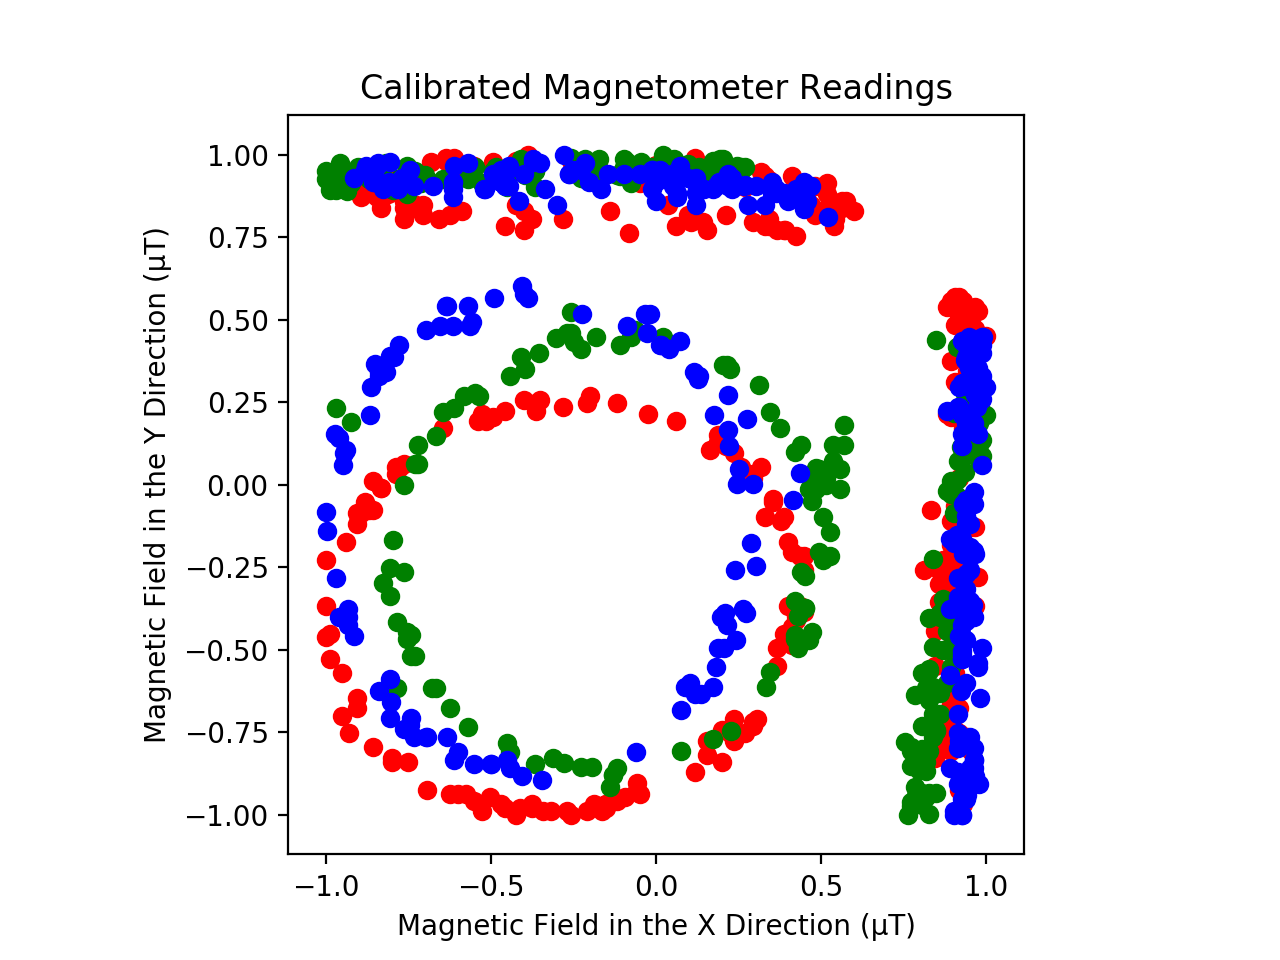

In [6]:
x_min = min(x_raw)
x_max = max(x_raw)
y_min = min(y_raw)
y_max = max(y_raw)
z_min = min(z_raw)
z_max = max(z_raw)

print("X range: ", x_min, x_max)
print("Y range: ", y_min, y_max)
print("Z range: ", z_min, z_max)

mag_calibration = [[x_min, x_max], [y_min, y_max], [z_min, z_max]]
print("Final calibration in uTesla:", mag_calibration)

cal_mag_x = [calibrate_magnetometer(x, x_min, x_max) for x in x_raw]
cal_mag_y = [calibrate_magnetometer(y, y_min, y_max) for y in y_raw]
cal_mag_z = [calibrate_magnetometer(z, z_min, z_max) for z in z_raw]

fig_calibrated_mag, ax_calibrated_mag = plt.subplots(1, 1)
ax_calibrated_mag.set_aspect(1)

plt.title("Calibrated Magnetometer Readings")
plt.xlabel("Magnetic Field in the X Direction (μT)")
plt.ylabel("Magnetic Field in the Y Direction (μT)")

# Display the now calibrated data
ax_calibrated_mag.scatter(cal_mag_x, cal_mag_y, color='r')
ax_calibrated_mag.scatter(cal_mag_y, cal_mag_z, color='g')
ax_calibrated_mag.scatter(cal_mag_z, cal_mag_x, color='b')
plt.show()

## Validate Calibrated Magnetometer Readings

Gently rotate the SCUTTLE again in two directions, x and y. The output figure should look the same as the calibrated magnetometer readings above. 
As long as we can see three axis circles are overlapping and all the new measurements are normalized within -1 and 1, the validation is completed. 

<IPython.core.display.Javascript object>


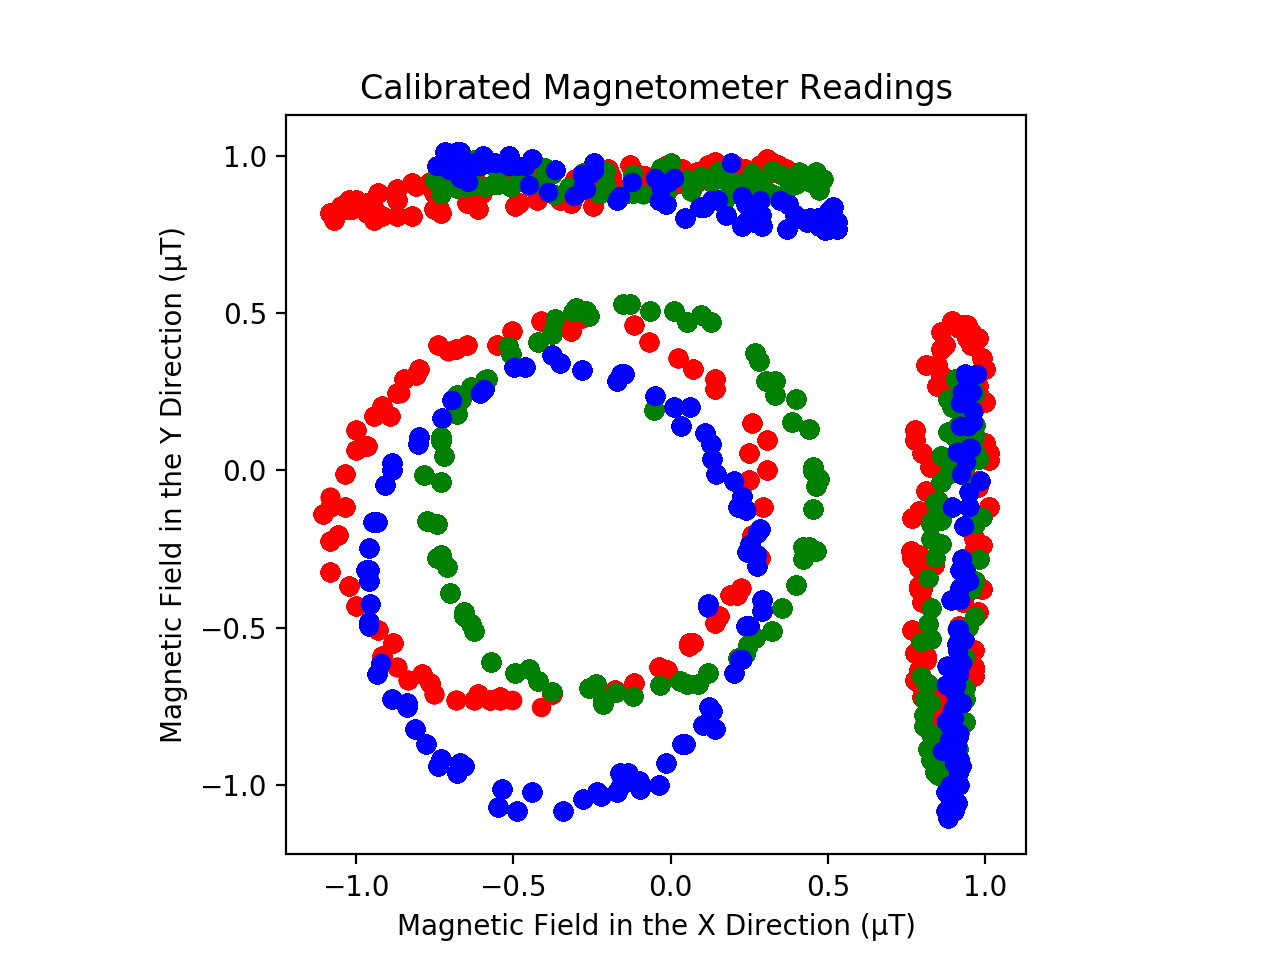

In [8]:
x_raw.clear()
y_raw.clear()
z_raw.clear()
t.clear()

fig_mag, ax_mag = plt.subplots()

plt.title("Calibrated Magnetometer Readings")
plt.xlabel("Magnetic Field in the X Direction (μT)")
plt.ylabel("Magnetic Field in the Y Direction (μT)")

ax_mag.set_aspect(1)

def animate(i):
    
    x, y, z = imu.magnetic
    
    if x is not None and y is not None and z is not None: 
        x = calibrate_magnetometer(x, x_min, x_max)
        y = calibrate_magnetometer(y, y_min, y_max)
        z = calibrate_magnetometer(z, z_min, z_max)

        if abs(x) < 500 and abs(y) < 500 and abs(z) < 500:
            x_raw.append(x)
            y_raw.append(y)
            z_raw.append(z)

        ax_mag.scatter(x_raw, y_raw, color='r')
        ax_mag.scatter(y_raw, z_raw, color='g')
        ax_mag.scatter(z_raw, x_raw, color='b')

    plt.pause(interval)
    
ani = animation.FuncAnimation(fig_mag, animate, interval=100)
plt.show()

### Calculate A Compass Heading

The result would be similar to Figure 5 in the lab 3 manual where the Y axis (Green) is shifted 90 degrees apart from the X axis (Red). 

<IPython.core.display.Javascript object>


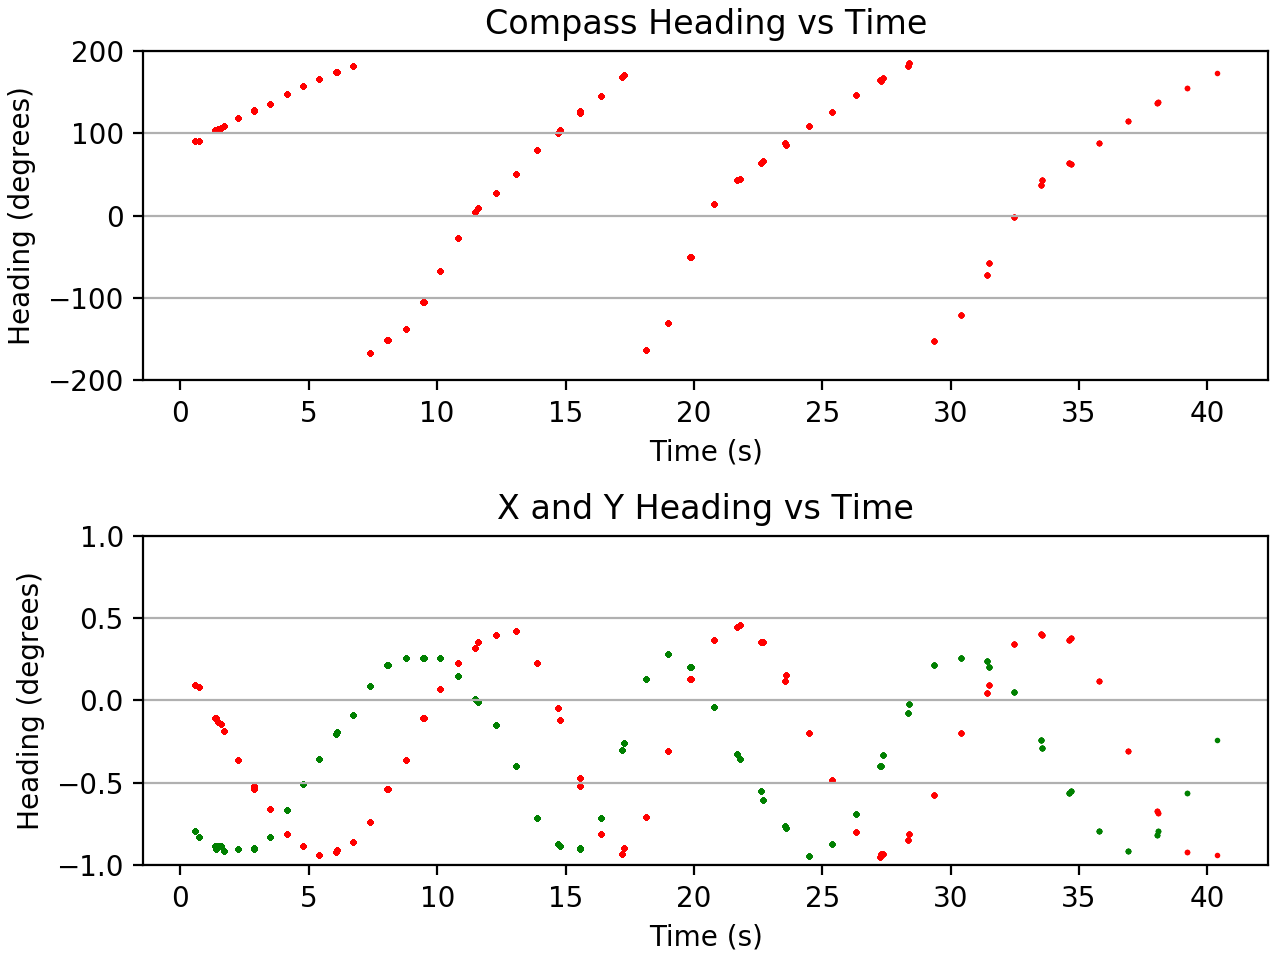

In [9]:
fig_heading, (ax_compass_heading, ax_calibrated_mag_reading) = plt.subplots(2, 1, constrained_layout=True)

ax_compass_heading.set_title("Compass Heading vs Time")
ax_compass_heading.set_xlabel("Time (s)")
ax_compass_heading.set_ylabel("Heading (degrees)")
ax_compass_heading.grid(axis = 'y')

ax_calibrated_mag_reading.set_title("X and Y Heading vs Time")
ax_calibrated_mag_reading.set_xlabel("Time (s)")
ax_calibrated_mag_reading.set_ylabel("Heading (degrees)")
ax_calibrated_mag_reading.grid(axis = 'y')

declination_angle = 7

ax_compass_heading.set_ylim(-200, 200)
ax_calibrated_mag_reading.set_ylim(-1, 1)

h.clear()
t.clear()

start_time = time.monotonic()

x_calibrated = []
y_calibrated = []

def animate(i):
    
    x, y, _ = imu.magnetic

    if x is not None and y is not None: 
        x = calibrate_magnetometer(x, x_min, x_max)
        y = calibrate_magnetometer(y, y_min, y_max)

        x_calibrated.append(x)
        y_calibrated.append(y)

        t.append(time.monotonic()-start_time)

        ax_calibrated_mag_reading.scatter(t, x_calibrated, s=1, color='r')
        ax_calibrated_mag_reading.scatter(t, y_calibrated, s=1, color='g')

        heading = np.degrees(np.arctan2(y,x))-declination_angle
        heading = -heading
        h.append(heading)

        ax_compass_heading.scatter(t, h, s=1, color='r')
    
ani = animation.FuncAnimation(fig_heading, animate, interval=100)
plt.show()